 

# Mean field Floquet dynamics



We introduce the position-momentum conjugate and effective Planck constant $1/N$ the Schroedinger equation becomes-
$$\frac{i}{N} \frac{\partial}{\partial t}\psi_t(q) = \mathcal{H}\psi_t(q)$$
Where hamiltonian 
$$H = -2q^2 -h(t)\sqrt{(1-4q^2)}cos(p)$$
Now we want to find one cycle evolution for Floquet matrix.
The initial condition for wave function is a unitary matrix of which each column is the nth state's initial condition. This means we have to descretize the position as well as momentum space with descrete Hamiltonian.
<br> The position space spans as-
$$
q = (q_0, q_1,q_2,....,q_{N-1})
$$
And momentum is related with position as-
$$
p = \frac{i}{N}\frac{\partial}{\partial q}
$$
So we can write-
$$ \mathcal{H} {|\psi\rangle} = \frac{i}{N}\frac{\partial{|\psi\rangle}}{\partial t}$$
Here the wavefunction-
$$
|\psi \rangle = \left(\begin{array}(
|\psi_0 \rangle\\
|\psi_1 \rangle\\
|\psi_2 \rangle\\
..\\
..\\
|\psi_{N-1} \rangle
\end{array}\right)
$$

Now we can write momentum in descerte space with finite difference method as- 
$$
p^n |\psi\rangle = \frac{i^n}{N^n}\frac{\partial ^n}{\partial q ^n}|\psi\rangle \Longrightarrow^{discrete} \sum_{j=0}^{n} (-1)^j C^{n}_{j} |\psi\rangle_{k+(\frac{n}{2}-j)} = \left(p^n |\psi\rangle \right)_k
$$

<br> McLaurent series for cos(p)-
$$
\left(cos(p) |\psi\rangle \right)_k = \sum_{l=0}^{N} \frac{(-1)^l p^{2l}}{2l!} = \sum_{l=0}^{N} \sum_{j=0}^{l} \frac{(-1)^{(l+j)}}{2l!} C^{l}_{j} |\psi\rangle_{k +(l-j)}
$$

<br> Here j,k,l are integers only.
Now,
$$
\left(\mathcal{H}|\psi\rangle \right)_k = \widetilde{H}_{km} \psi_m
$$
here $C^{n}_{j}$ is for binomial combination.

We are tried to get the floquet mean field dynamics when the dynamics follows a  specific path. We consoder to work inside first order brillauin zone.

References:
[1] Check T. Mori's paper equation (12)

time taken 67.28188824653625


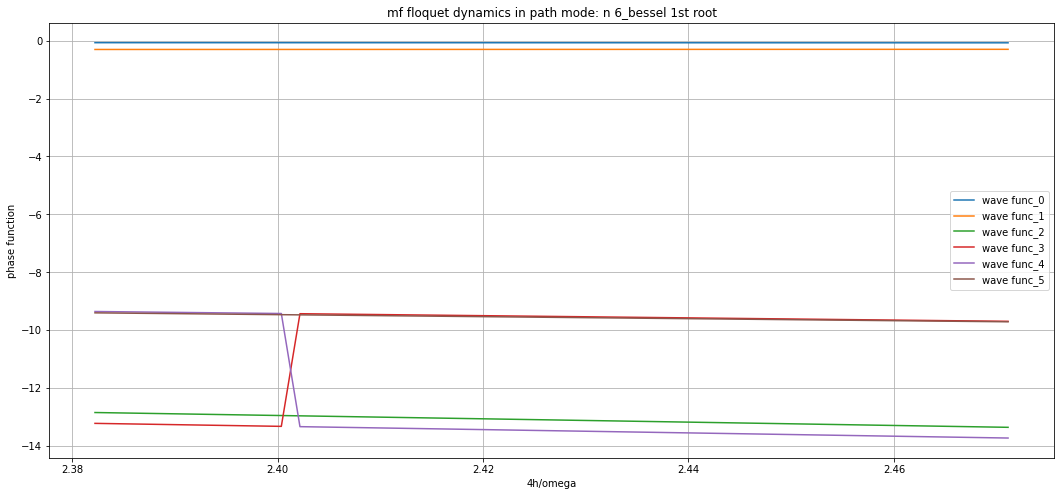

In [23]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import time
import math

start = time.time()
   
N = 6
h0 = 0.1 
tsteps = 100                        # number of increment in time
hsteps = 50                         # number of increment in h
hs = np.linspace(26.8,27.8,hsteps)
q = np.linspace(-0.5, 0.5, N)
omega = 45.0
w = omega
T = 2 * np.pi/w                            
t = np.linspace(0,T,tsteps)

psi = np.eye(N) + 1j * np.zeros((N,N))
cospp = np.zeros((N,N)) + 1j * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + 1j * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
phasefunc_path = np.zeros(len(hs))
prob = np.zeros(N)
title = "mf floquet dynamics in path mode: n " + str(N) + "_bessel 1st root"
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path_bessel1.jpeg"
filename = []

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(psi0,t,h,h0,w,cosp,q):
    drive = h0  + h * np.cos(w * t)
    jac = (-1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q * q) * cospp)
    return jac

def floq_func(psi0,t,h,h0,w,cosp,q):
    return np.dot(floq_jac(psi0,t,h0,h,w,cosp,q), psi0)

def binomial(n, k):
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in np.arange(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok

if __name__ == '__main__':   
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          binomial(l,j)* periodic_psi[(k+(l-j),(m))]])
            cospp[k,m] = cospinit
            cospinit = 0.0
    
    plt.figure(figsize = (18,8))
    plt.title(title)
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")        
    
    qq = q * np.eye(N)
    
    for nn in np.arange(N):
        labelname = 'wave func_' + str(nn)
        filename = str(N) + '_wave_' + str(nn)+".txt"
        # calculate for first "h"
        h = hs[0]           
        floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]  
            cosp = cospp[mm]
            q = qq[mm]
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,q), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[N-1]
    
        #print('flomat',floqEvolution_mat)
        evals, evecs = eig(floqEvolution_mat)
        phasefunc = (1j * np.log(evals[nn]))/T
        evecs_path = evecs[nn]                # normalisation done
        phasefunc_path[0] = phasefunc.real
    
        # calculate for rest of the "h"
        for cc, h in enumerate(hs[1:len(hs)]):   
            floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))        
            for mm in np.arange(N):
                psi0 = periodic_psi[mm]  
                cosp = cospp[mm]
                q = qq[mm]
                psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,q), Dfun=floq_jac)
                floqEvolution_mat[mm] = psi_t[N-1] 
            evals, evecs = eig(floqEvolution_mat)
            prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path/np.linalg.norm(evecs_path)).T,x/np.linalg.norm(x)),evecs)))
            for i,pr in enumerate(prob):
                if (pr.real >=.99):
                    pp = i
                    break
            
            evecs_path = evecs[pp]
            phasefunc = (1j * np.log(evals[pp]))/T
            phasefunc_path[cc+1] = phasefunc.real                
    
        
        #np.savetxt(filename,np.vstack((4*hs/w,phasefunc_path)).T)
        plt.plot(4*hs/w,phasefunc_path,label = labelname)
        #plt.scatter(4*hs/w,phasefunc_path)
        #plt.xlim(8.2,9.75)
        plt.legend()
    plt.grid()
    print('time taken',time.time()-start)
    plt.show()

time taken 308.2806785106659


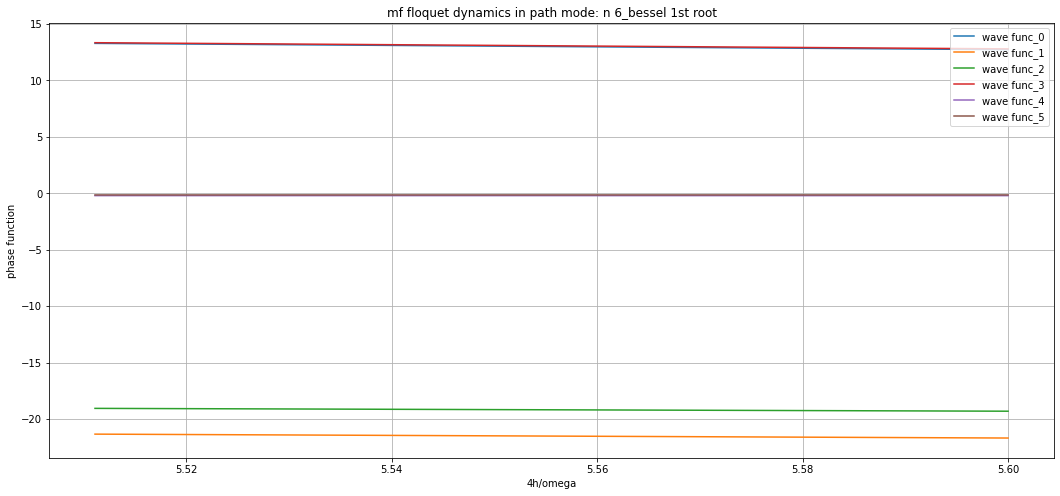

In [24]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import time
import math

start = time.time()
   
N = 6
h0 = 0.1 
tsteps = 100                        # number of increment in time
hsteps = 50                         # number of increment in h
hs = np.linspace(62.0,63.0,hsteps)
q = np.linspace(-0.5, 0.5, N)
omega = 45.0
w = omega
T = 2 * np.pi/w                            
t = np.linspace(0,T,tsteps)

psi = np.eye(N) + 1j * np.zeros((N,N))
cospp = np.zeros((N,N)) + 1j * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + 1j * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
phasefunc_path = np.zeros(len(hs))
prob = np.zeros(N)
title = "mf floquet dynamics in path mode: n " + str(N) + "_bessel 1st root"
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path_bessel1.jpeg"
filename = []

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(psi0,t,h,h0,w,cosp,q):
    drive = h0  + h * np.cos(w * t)
    jac = (-1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q * q) * cospp)
    return jac

def floq_func(psi0,t,h,h0,w,cosp,q):
    return np.dot(floq_jac(psi0,t,h0,h,w,cosp,q), psi0)

def binomial(n, k):
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in np.arange(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok

if __name__ == '__main__':   
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          binomial(l,j)* periodic_psi[(k+(l-j),(m))]])
            cospp[k,m] = cospinit
            cospinit = 0.0
    
    plt.figure(figsize = (18,8))
    plt.title(title)
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")        
    
    qq = q * np.eye(N)
    
    for nn in np.arange(N):
        labelname = 'wave func_' + str(nn)
        filename = str(N) + '_wave_' + str(nn)+".txt"
        # calculate for first "h"
        h = hs[0]           
        floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]  
            cosp = cospp[mm]
            q = qq[mm]
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,q), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[N-1]
    
        #print('flomat',floqEvolution_mat)
        evals, evecs = eig(floqEvolution_mat)
        phasefunc = (1j * np.log(evals[nn]))/T
        evecs_path = evecs[nn]                # normalisation done
        phasefunc_path[0] = phasefunc.real
    
        # calculate for rest of the "h"
        for cc, h in enumerate(hs[1:len(hs)]):   
            floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))        
            for mm in np.arange(N):
                psi0 = periodic_psi[mm]  
                cosp = cospp[mm]
                q = qq[mm]
                psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,q), Dfun=floq_jac)
                floqEvolution_mat[mm] = psi_t[N-1] 
            evals, evecs = eig(floqEvolution_mat)
            prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path/np.linalg.norm(evecs_path)).T,x/np.linalg.norm(x)),evecs)))
            for i,pr in enumerate(prob):
                if (pr.real >=.99):
                    pp = i
                    break
            
            evecs_path = evecs[pp]
            phasefunc = (1j * np.log(evals[pp]))/T
            phasefunc_path[cc+1] = phasefunc.real                
    
        
        #np.savetxt(filename,np.vstack((4*hs/w,phasefunc_path)).T)
        plt.plot(4*hs/w,phasefunc_path,label = labelname)
        #plt.scatter(4*hs/w,phasefunc_path)
        #plt.xlim(8.2,9.75)
        plt.legend()
    plt.grid()
    print('time taken',time.time()-start)
    plt.show()

In [17]:
# range of h

import numpy as np
omega = 45.0
bssl = np.array([2.40482555769577,5.52007811028631,8.65372791291101,11.7915344390142,14.9309177084877])
h = bssl * omega/4
print(h)

[ 27.05428752  62.10087874  97.35443902 132.65476244 167.97282422]


In [8]:
import numpy as np
g = np.arange(4)
h = np.arange(5,9)
for a,b in zip(g,h):
    print(a,b)